# Let's see if logistic IHT is working...

## First simulate some response

In [1]:
#load packages
using IHT
using SnpArrays
using DataFrames
using Distributions

#set random seed
srand(1111) 

#specify dimension and noise of data
n = 5000                        # number of cases
p = 30000                       # number of predictors
k = 10                          # number of true predictors per group
s = 0.1                         # noise vector, from very little noise to a lot of noise

#construct snpmatrix, covariate files, and true model b
x           = SnpArray(rand(0:2, n, p))    # a random snpmatrix
z           = ones(n, 1)                   # non-genetic covariates, just the intercept
true_b      = zeros(p)                     # model vector
true_b[1:k] = randn(k)                     # Initialize k non-zero entries in the true model
shuffle!(true_b)                           # Shuffle the entries
correct_position = find(true_b)            # keep track of what the true entries are
noise = rand(Normal(0, s), n)              # noise vectors from N(0, s) where s ∈ S = {0.01, 0.1, 1, 10}s

#compute mean and std used to standardize data to mean 0 variance 1
mean_vec, minor_allele, = summarize(x)
for i in 1:p
    minor_allele[i] ? mean_vec[i] = 2.0 - 2.0mean_vec[i] : mean_vec[i] = 2.0mean_vec[i]
end
std_vec = std_reciprocal(x, mean_vec)

#simulate phenotypes under different noises by: y = Xb + noise
y_temp = zeros(n)
SnpArrays.A_mul_B!(y_temp, x, true_b, mean_vec, std_vec)
y_temp .+= noise #add some noise

# Apply inverse logit link to map y to {0, 1} 
y = 1 ./ (1 .+ exp.(-y_temp)) #inverse logit link
y .= round.(y)                #map y to 0, 1

5000-element Array{Float64,1}:
 0.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 1.0
 1.0
 0.0
 0.0
 1.0
 0.0
 ⋮  
 0.0
 1.0
 1.0
 1.0
 0.0
 1.0
 1.0
 0.0
 1.0
 0.0
 0.0
 0.0

## Check if transformed data looks logistic (it does)

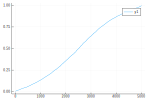

In [2]:
using Plots
temp = sort(1 ./ (1 .+ exp.(-y_temp)))
myplot = plot(collect(1:5000), temp)

## Now see if we can reconstruct the signal

In [2]:
#compute logistic IHT result 
estimated_models = zeros(k)
v = IHTVariables(x, z, y, 1, k)
result = L0_reg(v, x, z, y, 1, k, glm = "logistic")
estimated_models .= result.beta[correct_position]

#compare and contrast
true_model = true_b[correct_position]
compare_model = DataFrame(
    correct_position = correct_position, 
    true_β           = true_model,
    noise_level_1    = estimated_models)

current iteration is 1 and loss is Inf
current iteration is 2 and loss is 460.5003885210726
current iteration is 3 and loss is 460.5003885210721
current iteration is 4 and loss is 2552.499352464876
current iteration is 5 and loss is 6736.497280352489
current iteration is 6 and loss is 13012.494172183902
current iteration is 7 and loss is 21380.490027959124
current iteration is 8 and loss is 31840.48484767816
current iteration is 9 and loss is 44392.478631341
current iteration is 10 and loss is 59036.47137894766
current iteration is 11 and loss is 75772.46309049809
current iteration is 12 and loss is 94600.4537659924
current iteration is 13 and loss is 115520.44340543041
current iteration is 14 and loss is 138532.43200881232
current iteration is 15 and loss is 163636.41957613794
current iteration is 16 and loss is 190832.40610740747
current iteration is 17 and loss is 220120.39160262072
current iteration is 18 and loss is 251500.37606177788
current iteration is 19 and loss is 284972.359

LoadError: [91mInterruptException:[39m

In [4]:
x = copy(estimated_models)
# x .= log.(x ./ (1 .- x))
x ./ (1 .- x)

10-element Array{Float64,1}:
  0.0380224
  0.0729734
  0.0713741
  0.0      
 -0.0873905
 -0.109739 
 -0.0347556
 -0.0769761
  0.106646 
 -0.257513 